# Best-MLP

A better performing Multi-Layered Perceptron found by performing grid search to find the
best combination of hyper-parameters. For this, I experiment with the following parameter
values:

- activation function: sigmoid, tanh, relu and identity
- 2 network architectures of your choice: for eg 2 hidden layers with 30+50 nodes, 3 hidden layers
with 10+10
- solver: Adam and stochastic gradient descent

We start by importing the libraries.

In [8]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
from utils import config, ProcessDataset, model_utils
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Latin and Greek train and val data.

The data consists of 1025 columns, 1024 columns for each pixel and 1 row specifying the character it represents.
+ Calling helper method to load the dataset of training and validating

In [9]:
Latin_X_Train, Latin_Y_Train, Latin_X_Val, Latin_Y_Val = ProcessDataset.get_Latin_Train_Val()
Greek_X_Train, Greek_Y_Train, Greek_X_Val, Greek_Y_Val = ProcessDataset.get_Greek_Train_Val()

## Experimenting with different MLP parameters

- activation function: sigmoid, tanh, relu and identity
- 2 network architectures of your choice: for eg 2 hidden layers with 30+50 nodes, 3 hidden layers
with 10+10
- solver: Adam and stochastic gradient descent

From the geometric pyramid rule proposed by Masters, a rule for 3 hidden layers is $\sqrt{n}{m}$ where n is the input neurons and m the output neurons. Since there are 26 classes for latin and 10 classes for greek, we decided to try out a 3 hidden layer network of 26 neurons and 10 neurons.

### Set up the parameters for grid search

In [10]:
parameters = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [(26,26,26), (20,30)], 
    'solver':['adam','sgd']
}
clf_latin = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=10)

parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes': [(10,10,10), (20,30)], 
              'solver':['adam','sgd']}
clf_greek = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=10)

### Training the mlp model

The GridSearch will find the best combination of parameters that yield the best results. This can take quite some time as it is trying out every combination.

In [11]:
clf_latin.fit(Latin_X_Train, Latin_Y_Train)

clf_greek.fit(Greek_X_Train, Greek_Y_Train)

GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(10, 10, 10), (20, 30)],
                         'solver': ['adam', 'sgd']})

### Show the best parameters determined by GridSearch

In [12]:
def print_best_params(params, name):
    print('Best estimator for', name, 'MLP prediction')
    print('\tBest activation: ', params['activation'])
    print('\tBest hidden layer size: ', params['hidden_layer_sizes'])
    print('\tBest solver: ', params['solver'], '\n')

print_best_params(clf_latin.best_estimator_.get_params(), 'latin')
print_best_params(clf_greek.best_estimator_.get_params(), 'greek')

Best estimator for latin MLP prediction
	Best activation:  identity
	Best hidden layer size:  (20, 30)
	Best solver:  adam 

Best estimator for greek MLP prediction
	Best activation:  tanh
	Best hidden layer size:  (20, 30)
	Best solver:  sgd 



### Export models

In [13]:
from joblib import dump

dump(clf_latin, './models/BEST_MLP_clf_latin.joblib')
dump(clf_greek, './models/BEST_MLP_clf_greek.joblib')

['./models/BEST_MLP_clf_greek.joblib']

### Import models for evaluating

In [14]:
from joblib import load

clf_latin = load('./models/BEST_MLP_clf_latin.joblib')
clf_greek = load('./models/BEST_MLP_clf_greek.joblib')

### Validating the model with K-Fold Cross-Validation

In [15]:
kfold = KFold(n_splits=10, random_state=100)

results_kfold = cross_val_score(clf_latin, Latin_X_Val, Latin_Y_Val, cv=kfold)
print("Accuracy of latin prediction: %.2f%%" % (results_kfold.mean()*100.0)) 

results_kfold = cross_val_score(clf_greek, Greek_X_Val, Greek_Y_Val, cv=kfold)
print("Accuracy of greek prediction: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy of latin prediction: 55.05%
Accuracy of greek prediction: 82.94%


As we can see the accuracy is way better than than the BASE-MLP model.

## Test the models

### Load the test datasets


In [16]:
Latin_X_Test = np.array(ProcessDataset.get_DataFromCSV(config.LATIN_TEST_NOLABEL))
Latin_Y_Test = np.array(ProcessDataset.get_DataFromCSV(config.LATIN_TEST_LABEL))[:,1024]

Greek_X_Test = np.array(ProcessDataset.get_DataFromCSV(config.GREEK_TEST_NOLABEL))
Greek_Y_Test = np.array(ProcessDataset.get_DataFromCSV(config.GREEK_TEST_LABEL))[:,1024]

### Make prediction and export results to `csv` files

In [17]:
Latin_Y_Pred = clf_latin.predict(Latin_X_Test)
pd.DataFrame(Latin_Y_Pred).to_csv(os.path.join(config.OUTPUT_PATH, "BEST-MLP-DS1.csv"), header=None)

Greek_Y_Pred = clf_greek.predict(Greek_X_Test)
pd.DataFrame(Greek_Y_Pred).to_csv(os.path.join(config.OUTPUT_PATH,"BEST-MLP-DS2.csv"), header=None)

## Assert the accuracy of the models:

### 1. Confusion Matrix

#### Latin Character Predicition Model:

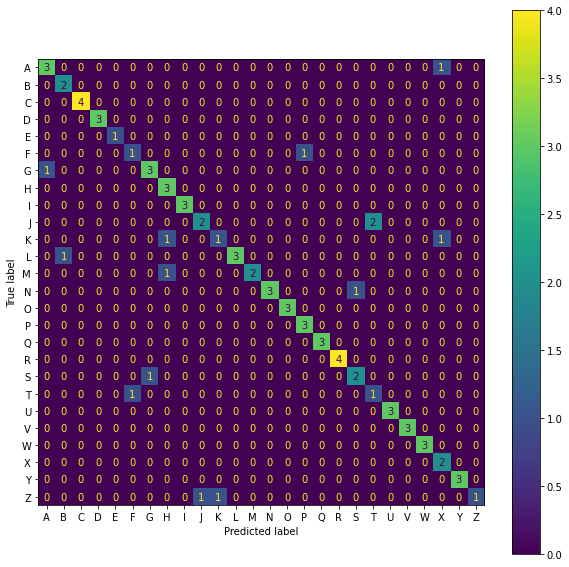

In [18]:
model_utils.show_confusion_matrix(clf_latin, Latin_X_Test, Latin_Y_Test, isGreekLetter=False)

#### Greek Character Prediction Model:

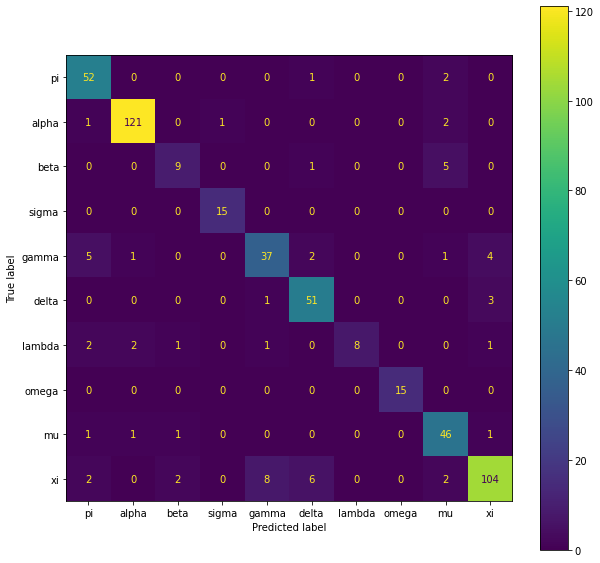

In [19]:
model_utils.show_confusion_matrix(clf_greek, Greek_X_Test, Greek_Y_Test, isGreekLetter=True)

### 2. Precision, recall, and f1-measure for each class

#### Latin Character Prediciton Model:

In [20]:
model_utils.calculate_PRF(Latin_Y_Test, Latin_Y_Pred)

,precision,recall,f1
0,0.750000,0.750000,0.750000
1,0.666667,1.000000,0.800000
2,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000
5,0.500000,0.500000,0.500000
6,0.750000,0.750000,0.750000
7,0.600000,1.000000,0.750000
8,1.000000,1.000000,1.000000
9,0.666667,0.500000,0.571429


#### Greek Character Prediction Model:

In [21]:
model_utils.calculate_PRF(Greek_Y_Test, Greek_Y_Pred)

,precision,recall,f1
0,0.825397,0.945455,0.881356
1,0.968000,0.968000,0.968000
2,0.692308,0.600000,0.642857
3,0.937500,1.000000,0.967742
4,0.787234,0.740000,0.762887
5,0.836066,0.927273,0.879310
6,1.000000,0.533333,0.695652
7,1.000000,1.000000,1.000000
8,0.793103,0.920000,0.851852
9,0.920354,0.838710,0.877637


### 3. Accuracy, macro-average f1 and weighted-average f1 of the model

#### Best-MLP model on DS1 - Latin characters

In [22]:
print("Accuracy of best-MLP model on DS1: " + str(accuracy_score(Latin_Y_Test, Latin_Y_Pred)*100)+"%")
print("Macro-average f1 of best-MLP model on DS1: " + str(f1_score(Latin_Y_Test, Latin_Y_Pred, average='macro')*100)+"%")
print("Weighted-average best-MLP model on DS1: " + str(f1_score(Latin_Y_Test, Latin_Y_Pred, average='weighted')*100)+"%")

Accuracy of best-MLP model on DS1: 82.27848101265823%
Macro-average f1 of best-MLP model on DS1: 81.25457875457876%
Weighted-average best-MLP model on DS1: 82.02230259192285%


#### Best-MLP model on DS2 - Greek characters

In [23]:
print("Accuracy of best-MLP model on DS1: " + str(accuracy_score(Greek_Y_Test, Greek_Y_Pred)*100)+"%")
print("Macro-average f1 of best-MLP model on DS1: " + str(f1_score(Greek_Y_Test, Greek_Y_Pred, average='macro')*100)+"%")
print("Weighted-average f1 of best-MLP model on DS1: " + str(f1_score(Greek_Y_Test, Greek_Y_Pred, average='weighted')*100)+"%")

Accuracy of best-MLP model on DS1: 88.2466281310212%
Macro-average f1 of best-MLP model on DS1: 85.27293109876717%
Weighted-average f1 of best-MLP model on DS1: 88.05285948543809%


## Conclusion

As we can see, the accuracy of the model greatly improved from the BASE-MLP.